In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [108]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import LdaModel
from gensim.models import Phrases
from itertools import chain
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
%matplotlib inline

In [4]:
train = pd.read_csv('../data/external/kaggle/train.csv')
test = pd.read_csv('../data/external/kaggle/test.csv')
y = pd.read_csv('../data/external/kaggle/train.csv')['target'].values
tokenizer = RegexpTokenizer(r'\w+')

In [101]:
def preview_corpus(corpus):
    for i,doc in enumerate(corpus[:5],1):
        print(f'Item {i}: {doc}')
        print()
        
def display_corr(df, s=10):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(s,s))
    ax = sns.heatmap(corr.round(3),mask=mask, annot=True, cbar=False, linewidths=0.3, square=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize='x-large');
    return fig, ax

In [51]:
corpus = train['text'].values
corpus = [doc.lower() for doc in corpus]
corpus = [tokenizer.tokenize(doc) for doc in corpus]
corpus = [[token for token in doc if (not token.isnumeric() and len(token) > 1)] for doc in corpus]
preview_corpus(corpus)

Document 1: ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']

Document 2: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']

Document 3: ['all', 'residents', 'asked', 'to', 'shelter', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']

Document 4: ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'in', 'california']

Document 5: ['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'alaska', 'as', 'smoke', 'from', 'wildfires', 'pours', 'into', 'school']



In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [52]:
min_count_b = 5
min_count_t = 5
min_count_f = 5

In [53]:
%%time

bigram = Phrases(corpus, min_count=min_count_b)
trigram = Phrases(bigram[corpus], min_count=min_count_t)
fourgram = Phrases(trigram[corpus], min_count=min_count_f)
for doc in corpus:
    bigrams = [b for b in bigram[doc] if b.count('_') == 1]
    trigrams = [t for t in trigram[bigram[doc]] if t.count('_') == 2]
    fourgrams = [f for f in fourgram[trigram[bigram[doc]]] if f.count('_') == 3]
    doc.extend(list(chain(*[bigrams, trigrams, fourgrams])))
preview_corpus(corpus)

Document 1: ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']

Document 2: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada', 'forest_fire']

Document 3: ['all', 'residents', 'asked', 'to', 'shelter', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']

Document 4: ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'in', 'california']

Document 5: ['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'alaska', 'as', 'smoke', 'from', 'wildfires', 'pours', 'into', 'school', 'just_got']

CPU times: user 4.05 s, sys: 0 ns, total: 4.05 s
Wall time: 4.05 s


In [54]:
no_below = 100
no_above = 0.6
n_most_frequent = 0

In [55]:
dictionary = Dictionary(corpus)
dictionary.filter_extremes(no_below=no_below, no_above=no_above)
dictionary.filter_n_most_frequent(n_most_frequent)
corpus = [dictionary.doc2bow(doc) for doc in corpus]
preview_corpus(corpus)

Document 1: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

Document 2: [(6, 1)]

Document 3: [(0, 1), (1, 2), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1)]

Document 4: [(8, 1), (12, 1), (13, 1)]

Document 5: [(4, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1)]



In [56]:
print(f'Corpus: {len(corpus)} Tweets')
print(f'Dictionary: {len(dictionary)} Tokens')

Corpus: 7613 Tweets
Dictionary: 109 Tokens


In [63]:
pd.read_csv('../data/external/appen/disaster_response_messages_training.csv').columns

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['id', 'split', 'message', 'original', 'genre', 'related', 'PII',
       'request', 'offer', 'aid_related', 'medical_help', 'medical_products',
       'search_and_rescue', 'security', 'military', 'child_alone', 'water',
       'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees',
       'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')

In [78]:
num_topics = 8
chunksize = len(corpus)
passes = 5
iterations = 400
eval_every = None

In [79]:
%%time

temp = dictionary[0]  
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

CPU times: user 12.8 s, sys: 48 ms, total: 12.8 s
Wall time: 12.8 s


In [80]:
%%time
topics = [model.get_document_topics(doc) for doc in corpus]
topics = [dict(topic_dist) for topic_dist in topics]
topics = pd.DataFrame(topics).fillna(0)
topics['label'] = y
topics

CPU times: user 2.54 s, sys: 20.1 ms, total: 2.56 s
Wall time: 2.54 s


,0,1,2,3,4,5,6,7,label
0,0.010557,0.574898,0.349411,0.010964,0.011806,0.011474,0.019892,0.010997,1
1,0.637287,0.051627,0.052005,0.043604,0.046952,0.045633,0.079156,0.043735,1
2,0.000000,0.414658,0.533097,0.000000,0.000000,0.000000,0.013742,0.000000,1
3,0.019165,0.023566,0.023739,0.019903,0.021431,0.836044,0.036188,0.019963,1
4,0.000000,0.011292,0.011375,0.581784,0.349497,0.000000,0.017325,0.000000,1
...,...,...,...,...,...,...,...,...,...
7608,0.015069,0.018529,0.018664,0.015650,0.016851,0.871079,0.028461,0.015697,1
7609,0.000000,0.741679,0.000000,0.000000,0.000000,0.000000,0.215243,0.000000,1
7610,0.015069,0.018530,0.018664,0.015650,0.016851,0.016378,0.883161,0.015697,1
7611,0.548862,0.015267,0.015379,0.356747,0.013884,0.013494,0.023433,0.012933,1


In [81]:
#TO INVESTIGATE: THE LESS TOKENS, THE MORE CORRELATION (ENTRIES ZEROED OUT)
# THE MORE TOPICS, THE LESS CORRELATIONS (ENTRIES ZEROED OUT)

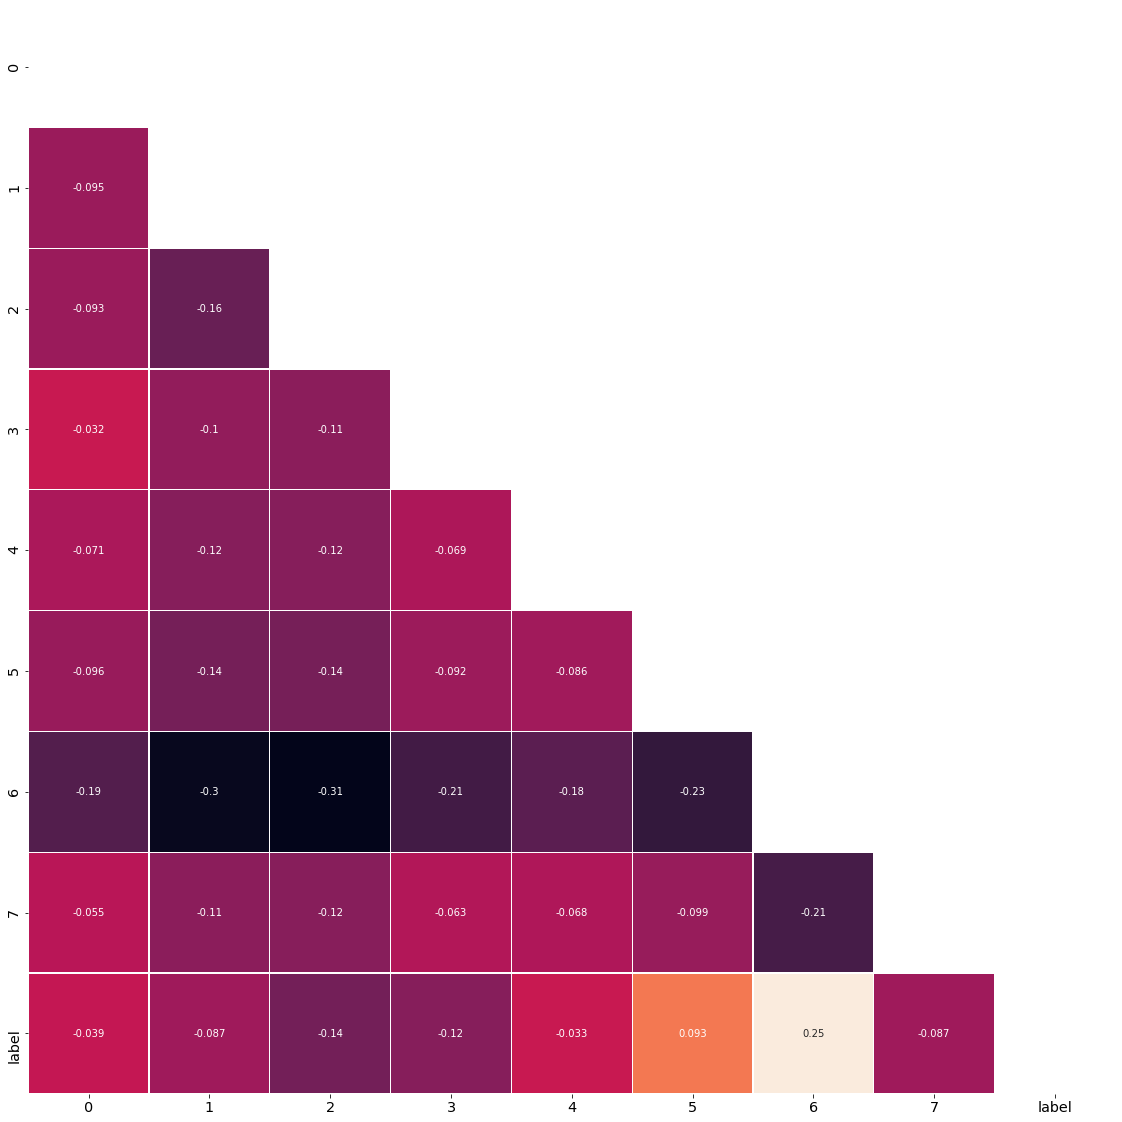

In [82]:
_,_ = display_corr(topics, 20)

In [100]:
t = [l for i,l in model.show_topics(formatted=False, num_words=100)]
t = [list(zip(*l))[0] for l in t]
preview_corpus(t)

Document 1: ('with', 'of', 'the', 'has', 'this', 'up', 'at', 'on', 'his', 'some', 'is', 'her', 'that', 'man', 'fire', 'he', 'over', 'been', 'an', 'people', 'and', 'to', 'no', 'just', 'not', 'how', 'still', 'in', 'see', 'body', 'all', 'now', 'there', 'out', 'after', 'are', 'will', 'like', 'û_', 'co', 'them', 'were', 'know', 'who', 'by', 'when', 'http', 'me', 'http_co', 'you', 'more', 'storm', 'was', 'news', 'as', 'get', 'do', 'would', 'first', 'so', 'we', 'be', 'my', 'but', 'from', 'don', 'what', 'rt', 'police', 'why', 'fires', 'emergency', 'got', 'your', 'amp', 'or', 'about', 'it', 'for', 'off', 'if', 'day', 'suicide', 'new', 'û__http_co', 'back', 'disaster', 'https', 'have', 'one', 'than', 'https_co', 'crash', 'going', 'can', 'via', 'us', 'into', 'buildings', 'video')

Document 2: ('the', 'to', 'of', 'that', 'and', 'it', 'is', 'in', 'was', 'on', 'my', 'about', 'all', 'by', 'are', 'at', 'out', 'into', 'he', 'you', 'with', 'just', 'for', 'off', 'one', 'from', 'like', 'be', 'as', 'going'

In [96]:
model.show_topics?

In [18]:
print(model.show_topic(1))

[('fedex', 0.0041247485), ('bioterror', 0.0037652405), ('longer', 0.0034095093), ('fedex_no', 0.002865683), ('famine', 0.0028335315), ('transport', 0.0027458353), ('lab', 0.0027454724), ('food', 0.002662932), ('see', 0.002634257), ('black', 0.0025800942)]


In [102]:
# import pyLDAvis
from pyLDAvis import gensim as ldavis
# pyLDAvis.enable_notebook()
vis = ldavis.prepare(model, corpus, dictionary)
#vis

In [106]:
import pyLDAvis
pyLDAvis.enable_notebook()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
vis

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.234823  0.028492       1        1  30.534693
2      0.142995 -0.026790       2        1  15.812566
1      0.110913  0.007458       3        1  15.174012
5     -0.159219 -0.001432       4        1   9.611457
7      0.046068 -0.153717       5        1   7.803989
3      0.075578 -0.007827       6        1   7.298535
4     -0.099408  0.004576       7        1   7.009394
0      0.117894  0.149239       8        1   6.755354, topic_info=       Term         Freq        Total Category  logprob  loglift
43     http  4168.000000  4168.000000  Default  30.0000  30.0000
44  http_co  3932.000000  3932.000000  Default  29.0000  29.0000
42       co  4590.000000  4590.000000  Default  28.0000  28.0000
3       the  3331.000000  3331.000000  Default  27.0000  27.0000
71    https   401.000000   401.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
28       is    93.893490   979.018529   Topic8  -3.5853   0.3504
3       the   147.114488  3331.019570   Topic8  -3.1362  -0.4250
20      and    63.901104  1440.629290   Topic8  -3.9701  -0.4207
11       to    59.783593  1923.058516   Topic8  -4.0367  -0.7761
8        in    43.069669  1981.052081   Topic8  -4.3646  -1.1337

[344 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
75        1  0.156391       about
75        2  0.027598       about
75        3  0.542769       about
75        4  0.133392       about
75        5  0.101194       about
...     ...       ...         ...
103       1  0.922152  û__http_co
103       2  0.006148  û__http_co
103       5  0.018443  û__http_co
103       7  0.043034  û__http_co
103       8  0.012295  û__http_co

[832 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 2, 6, 8, 4, 5, 1])